In [1]:
%run /Users/pnl0rc8b@emea.royalahold.net/Functions_Rebuild

In [2]:
%run /Users/pnl0rc8b@emea.royalahold.net/Functions_Formateren

In [3]:
ATTRIBUUT = "ndTypeOfGrain" # Selecteer Attribuut
Classes_threshold = 11
Overig_threshold = 300 # Class beneden deze threshold, zal worden toegevoegd aan class: 'overig'

Multi_label = False

numerieke_features = ['FIBER']

# Fix empty rows

In [5]:
nd_controle = koppel_ndAttributen()
df_geformateerd, multi_label_flag,classes_available = create_overige_class(nd_controle, ATTRIBUUT,Classes_threshold, Overig_threshold)

DF_merged = koppel_preprocessed_text(df_geformateerd)
DF_merged = fix_empty_fields(DF_merged, ATTRIBUUT)

Amount of rows: (33455, 'Amount of columns: ', 134)
ATTRIBUUT: ndTypeOfGrain
Kleine classes die onder overige moeten: ['Amarant', 'Boekweit', 'Bulgur', 'Durum', 'Eenkoorn', 'Emmer', 'Freekeh', 'Gierst', 'Kamut', 'Quinoa', 'Sorghum', 'Spelt', 'Teff']
Grotere classes: ['EMPTY', 'Gerst', 'Haver', 'Mais', 'Rijst', 'Rogge', 'Tarwe']
null entries = 0
Shape van dataframe: (23424, 33)
null entries = 1474

<BarContainer object of 9 artists> <class 'matplotlib.container.BarContainer'>

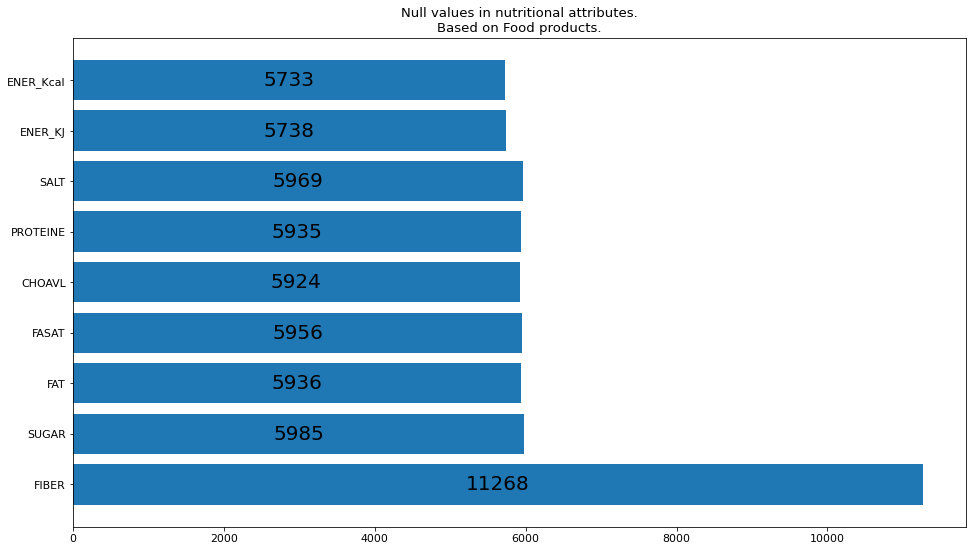

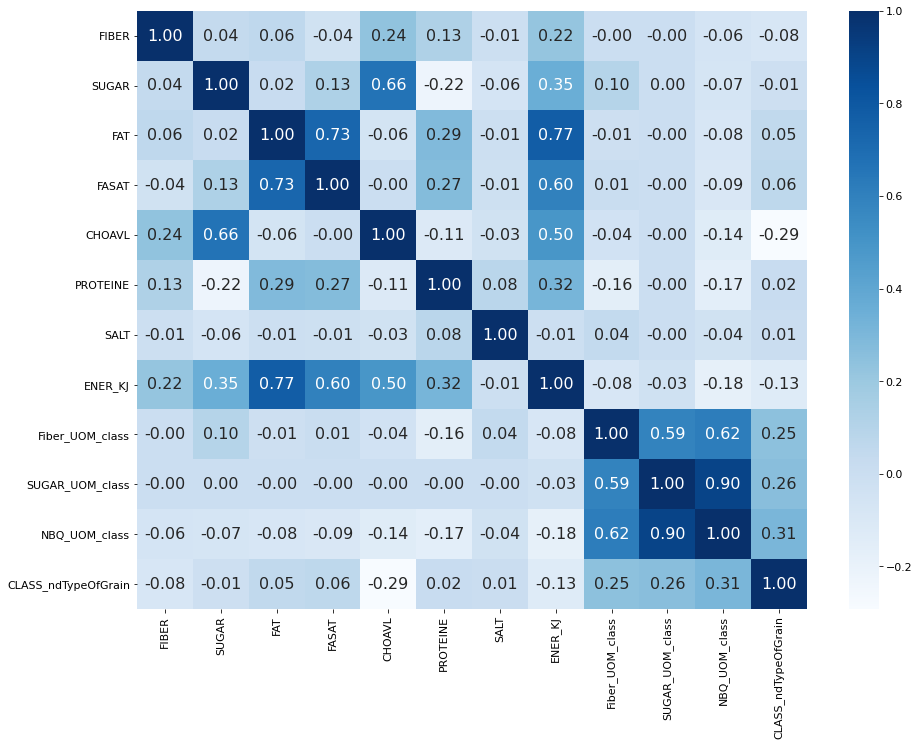

In [6]:
DF_merged = Correlation_matrix(DF_merged, ATTRIBUUT)

# Load models from database, ndTypeOfGrain exists out of multiple models.

In [8]:
TARGETS = DF_merged['class_names_'+ATTRIBUUT].tolist()
TARGETS = TARGETS[0]
print(TARGETS)

numerical, text, target_unused, vocab_size_unused = single_prep_controle(numerieke_features, DF_merged, ATTRIBUUT)

['EMPTY', 'Gerst', 'Haver', 'Mais', 'Rijst', 'Rogge', 'Tarwe', 'overig']
Vocabular size: 41228.0
Numerical Features: Index(['FIBER'], dtype='object')
Shape Numerical Features: (21950, 1)
Shape Text Features: (21950, 301)
Shape Targets: (21950, 8, 2)

In [9]:

from tensorflow import keras
all_model_files = dbutils.fs.ls("dbfs:/FileStore/nd_MODELS_publicatie/"+str(ATTRIBUUT))
#print(all_model_files)
controle_tabel = DF_merged[['gtin','gln','Lemmatized',ATTRIBUUT]]
total_pred = []
total_test = []
class_names = []

for index, model in enumerate(all_model_files): # loop through all models
    print(model.path)
    dbutils.fs.cp(model.path, "file:/FileStore/nd_MODELS_publicatie/"+str(ATTRIBUUT)+"/"+model.name)
    model = keras.models.load_model("/FileStore/nd_MODELS_publicatie/"+str(ATTRIBUUT)+"/"+model.name)

    # TARGET
    target = TARGETS[index]
    print(target)
    
    y_target = DF_merged[str(target)].tolist()
    y_target_tensor = torch.FloatTensor(y_target)
    y_target = y_target_tensor.numpy()
    print(numerical.shape, text.shape, y_target.shape)

    # Predictions
    list_ytest, list_yhat, yhat2 = predictions_2inputs(model, numerical, text, y_target)
    
    controle_tabel['TRUE '+str(target)] = list_ytest
    controle_tabel['PRED '+str(target)] = list_yhat
    total_test.append(list_ytest)
    total_pred.append(list_yhat)
    class_names.append(target)

dbfs:/FileStore/nd_MODELS_publicatie/ndTypeOfGrain/model_EMPTY.h5
EMPTY
(21950, 1) (21950, 301) (21950, 2)
 1/686 [..............................] - ETA: 5:26 6/686 [..............................] - ETA: 6s  32/686 [>.............................] - ETA: 2s 66/686 [=>............................] - ETA: 1s 98/686 [===>..........................] - ETA: 1s130/686 [====>.........................] - ETA: 1s164/686 [======>.......................] - ETA: 0s194/686 [=======>......................] - ETA: 0s227/686 [========>.....................] - ETA: 0s259/686 [==========>...................] - ETA: 0s294/686 [===========>..................] - ETA: 0s328/686 [=============>................] - ETA: 0s363/686 [==============>...............] - ETA: 0s393/686 [================>.............] - ETA: 0s426/686 [=================>............] - ETA: 0s460/686 [===================>..........] - ETA: 0s494/686 [====================>.........] - ETA: 0s528/686 [======================>.......] - ETA: 0s563/686 [=======================>......] - ETA: 0s596/686 [=========================>....] - ETA: 0s628/686 [==========================>...] - ETA: 0s662/686 [===========================>..] - ETA: 0s686/686 [==============================] - 2s 2ms/step
 1/686 [..............................] - ETA: 7:18 - loss: 0.2592 - accuracy: 0.9688 23/686 [>.............................] - ETA: 1s - loss: 0.1041 - accuracy: 0.9728  54/686 [=>............................] - ETA: 1s - loss: 0.0993 - accuracy: 0.9780 84/686 [==>...........................] - ETA: 1s - loss: 0.1101 - accuracy: 0.9728113/686 [===>..........................] - ETA: 1s - loss: 0.0993 - accuracy: 0.9754145/686 [=====>........................] - ETA: 0s - loss: 0.0995 - accuracy: 0.9748171/686 [======>.......................] - ETA: 0s - loss: 0.1076 - accuracy: 0.9726204/686 [=======>......................] - ETA: 0s - loss: 0.1081 - accuracy: 0.9729233/686 [=========>....................] - ETA: 0s - loss: 0.1088 - accuracy: 0.9724261/686 [==========>...................] - ETA: 0s - loss: 0.1085 - accuracy: 0.9725

In [10]:
# TABLE predictions to the right format
total_test_T = np.array(total_test)
total_test_T = total_test_T.T
total_test_T = total_test_T.tolist()
total_pred_T = np.array(total_pred)
total_pred_T = total_pred_T.T
total_pred_T = total_pred_T.tolist()


# convert [0,0,0,0,0] into [1,0,0,0,0]
if ATTRIBUUT == 'ndAnimalSpecies':
    for index, row_pred in enumerate(total_pred_T):
        if row_pred == [0,0,0,0,0,0]:
            total_pred_T[index] = [0,1,0,0,0,0]
if ATTRIBUUT == 'ndTypeOfGrain':
    for index, row_pred in enumerate(total_pred_T):
        if row_pred == [0,0,0,0,0,0,0,0]:
            total_pred_T[index] = [1,0,0,0,0,0,0,0]
        
# Wanneer er empty + graan aanwezig is, verwijder dan empty. Alleen nodig bij multi-label models
prediction_new = []
for prediction in total_pred_T:
    if prediction.count(1) >1 and prediction[1]==1:
        prediction_cp = prediction
        prediction_cp[1] = 0
    else:
        prediction_cp = prediction
    prediction_new.append(prediction_cp)
    
controle_tabel['TRUE'] = total_test_T
controle_tabel['PREDICTED'] = prediction_new #total_pred_T
controle_tabel_T = controle_tabel[['gtin','gln','Lemmatized',ATTRIBUUT,'TRUE','PREDICTED']]

# Place labels in column
labels = DF_merged['class_names_'+ATTRIBUUT].tolist()
labels = labels[0]

total_labels = []
for row in controle_tabel_T['PREDICTED']:
    product_labels = []
    for index, label in enumerate(row):
        if label == 1:
            product_labels.append(labels[index])
    total_labels.append(product_labels)
controle_tabel_T['PREDICTED Labels'] = total_labels
controle_tabel_T

Out[211]:

,gtin,gln,Lemmatized,ndTypeOfGrain,TRUE,PREDICTED,PREDICTED Labels
0,42116776,5449000000002,frisdrank sinaasappelsap suiker zoetstof limon...,EMPTY,"[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]",[EMPTY]
1,42399520,8710642000017,frisdrank sinaasappelsap suiker zoetstof limon...,EMPTY,"[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]",[EMPTY]
2,50112821,8710642000017,frisdrank plantenextract zoetstof cola zero su...,EMPTY,"[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]",[EMPTY]
3,54001909,8722800000012,banaan los chiquita banaan chiquita banaan to ...,EMPTY,"[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]",[EMPTY]
4,54003842,5400207999995,cigarette pall mall red49 sigaret pall mall re...,EMPTY,"[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]",[EMPTY]
...,...,...,...,...,...,...,...
23419,9311218112067,8714253049021,wine rd red wine lindeman bin 45 cabernet sauv...,EMPTY,"[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]",[EMPTY]
23420,9311218122776,8714253049021,wine rd red wine lindeman bin 45 cabernet sauv...,EMPTY,"[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]",[EMPTY]
23421,9311220005685,8714253049021,wine wht white wine 19 crime chardonnay 19 cri...,EMPTY,"[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]",[EMPTY]
23422,9311220006057,8714253049021,wine wht white wine 19 crime sauv block 19 cri...,EMPTY,"[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]",[EMPTY]


# Compare

## UNEQUAL table

In [13]:
UNEQUAL_TABLE = controle_tabel_T.loc[~(controle_tabel_T['TRUE'] == controle_tabel_T['PREDICTED'])]
EQUAL_TABLE = controle_tabel_T.loc[(controle_tabel_T['TRUE'] == controle_tabel_T['PREDICTED'])]
UNEQUAL_TABLE.drop(columns=['TRUE','PREDICTED'], axis=1, inplace=True)
EQUAL_TABLE.drop(columns=['TRUE','PREDICTED'], axis=1, inplace=True)

print(len(UNEQUAL_TABLE))
display(UNEQUAL_TABLE)

2571

gtin,gln,Lemmatized,ndTypeOfGrain,PREDICTED Labels
54018037,8725000000011,bier speciaalbier leff leff bruin 30cl speciaalbi ingrediënt water gerstemout mais gerst suiker hop,EMPTY,List(Mais)
54018143,8725000000011,witbier speciaalbier hoegaarden hoegaarden witbi ingrediënt water gerstemout tarwe glucos siroop gist hop koriander drogen sinaasappelschil voedingszuur citroenzuur,Gerst|Tarwe,List(Tarwe)
54057197,8714252030303,speciaal bier bier cornet smoke cornet smoke 33cl bevatten gerstemout tarwemout,Gerst|Tarwe,List(Tarwe)
612322000783,5000235000009,glutenvrij haver tussendoortje grof haver puur chocola kokosnoot biscuit break nairn glut free dark chocolate coconut chunky oat biscuit break 12 stuk 160 g nairn biscuit break glut free dark chocolate coconut chunky oat 160 g doo ingrediënt glutenvrij volkorenhaver 58 duurzaam palm vruchtenolie puur chocoladestukje 10 suiker cacaomassa cacaoboter emulgeermiddel soja lecithine natuurlijk vanillesmaakstof bruine basterd suiker raspen kokosnoot 5 tapioca zetmeel deels geïnverteeren suikersiroop lyle gelden syrup rijsmiddel natriumcarbonaat ammonium bicarbonaat natuurlijk smaakstof zeezout bevatten mogelijk spoor melk we garanderen onze ingrediënt vrij noot zien allergeen vetgedrukt ingrediënt,Haver,"List(Haver, Rijst)"
3046920001472,8720098000004,assortiment 21 melk donker wit chocolade bonbon creation ballotin dessert lindt création dessert 200gram lindt creation ballotin dessert 200 gram ingrediëntensuiker cacaoboter cacaomassa melkpoeder water melkvet lactose hazelnootpraliné hazelnoot suiker 3 invertsuiker glucosesiroop plantaardig vet kokos palm hazelnoot 1 walnoot 1 wafel suiker tarwebloem watervrij melkvet weipoeder gerstemoutextract rijsmiddel sodiumcarbonaat stabilisatorsorbitol kaarmelstukje suiker lactose watervrij melkvet mager melkpoeder emulgator koolzaadlecithine 09 mager melkpoeder vetarm cacao emulgator sojalecithin koekkruimels tarwebloem suiker plantaardig olie kokosnoot zonnebloem glucos melkeiwitt rijsmiddel ammonium natriumcarbonat meringue melk suiker tarwezetmeel melkeiwitt 02 roompoeder krokant ontbijtgraan tarwebloem suiker tarwemout emulgator koolzaadlecithine rijsmiddel natriumbicarbonaat aroma mascarpone gerstemoutextract natuurlijk koffiearoma natuurlijk vanillearoma aroma vanill zout natuurlijk aroma glansmiddel arabisch gom melkeiwitt kleurstof paprikaextract stabilisator dinatriumfosfaat ei noot bevatten,Gerst|Tarwe,List(Tarwe)
3046920047937,8720098000004,fijn donker chocolade 70 cacao vullen karamel 20 truffel 10 chocolade lindt creation dark 70 caramel 150 gram lindt creation dark 70 caramel 150 gram ingrediënt cacaomassa suiker mager cacao watervrij melkvet cacaoboter melkpoeder invertsuiker glucosesiroop stabilisator sorbitol lactose mager melkpoeder emulgator sojalecithin zout 01 gerstemoutextract aroma conserveermiddel sorbinezuur tarwe ei noot bevatten donker chocolade bevatten cacaobestanddeel 70 minimum,Gerst|Tarwe,List(Tarwe)
3083681101843,3010836820304,snijden bloemkool diepvriezen diepvriesgroente bloemkool rijzen bonduell diepvriesgroente bloemkool rijzen 400 g stazak ingrediënt bloemkool selderij bevatten,EMPTY,"List(EMPTY, Rijst)"
3116430057587,3116430000101,koek chocolade koek wafel biscuit delacre marquisette 175 g marquisette 175 g ingrediënt tarwebloem plantaardig vet palm raapzaad chocolade 175 cacaomassa suiker cacaoboter boterolie emulgator sojalecithin suiker lactose melkeiwitt heeleipoeder zout natuurlijk aroma spoor bevatten hazelnoot noot haver gerst glut,Gerst|Haver|Tarwe,"List(Haver, Tarwe)"
3116430058164,3116430000101,koekjesassortiment koek wafel biscuit delacre tea time 500 g tea time 500 g ingrediënt tarwebloem suiker melkchocolade 15 suiker cacaoboter cacaomassa mager melkpoeder boterolie emulgator sojalecithin aroma plantaardig vet palm raapzaad palmpit kokosnoot chocolade 12 suiker cacaomassa cacaoboter boterolie emulgator sojalecithin wit chocolade 5 suiker cacaoboter mager melkpoeder weipoeder boterolie emulgator 

## EQUAL table

In [15]:
display(EQUAL_TABLE)

gtin,gln,Lemmatized,ndTypeOfGrain,PREDICTED Labels
42116776,5449000000002,frisdrank sinaasappelsap suiker zoetstof limonade fanta orange 250 ml fanta orange pet 025l 1x ingrediënt sprankelen water suiker sinaasappelsap sapconcentraat 6 voedingszur citroenzuur appelzuur natriumcitraat conserveermiddel kaliumsorbaat natuurlijk sinaasappelaroma natuurlijk aroma antioxidant ascorbinezuur zoetstof acesulfaamk aspartaam stabilisator guarpitmeel wortelconcentraat kleurstof caroten,EMPTY,List(EMPTY)
42399520,8710642000017,frisdrank sinaasappelsap suiker zoetstof limonade orange fanta orange fanta orange pet 0375l 1x ingrediënt sprankelen water sinaasappelsap concentraat 65 suiker voedingszur citroenzuur appelzuur natriumcitrat natuurlijk sinaasappelaroma ’s natuurlijk aroma ’s zoetstof natriumcyclamaat acesulfaamk sucralose conserveermiddel kaliumsorbaat antioxidant ascorbinezuur wortelconcentraat stabilisator guarpitmeel kleurstof caroten,EMPTY,List(EMPTY)
50112821,8710642000017,frisdrank plantenextract zoetstof cola zero sugar cocacola zero cocacola zero pet 0375l 1x ingrediënt sprankelen water kleurstof e150d voedingszuren e338 e331 zoetstof aspartaam acesulfaamk natuurlijk aroma plantenextract waaronder cafeïne,EMPTY,List(EMPTY)
54001909,8722800000012,banaan los chiquita banaan chiquita banaan to go pst,EMPTY,List(EMPTY)
54003842,5400207999995,cigarette pall mall red49 sigaret pall mall red49 pall mall red49,EMPTY,List(EMPTY)
54017016,8714253049021,bier bier maes pil fles 25 cl maes bier pil 25 cl fle ingrediënt water gerstemout glucosestroop hop hop extract,Gerst,List(Gerst)
54018204,8725000000011,onfilteren bier verfijnen krachtig toets speciaalbier leff leff tripel 30cl speciaalbier ingrediënt water gerstemout suiker kruid natuurlijk sinaasappelschil korianderzad hop,Gerst,List(Gerst)
54043121,5400207999995,winston red xxl 35 sigaret winston red xxl 35 winston red xxl 35 box,EMPTY,List(EMPTY)
54138094,5410146000003,vers kaasspecialiteit bosbes nietopgeklopt mager danio bosbe 180 g danio mg 180 bosbe ingrediënt mager vers kaas 41 melk afromen melk suiker vloeibaar suiker sacharos 10 room melk bosbe 42 zwart bes 28 melkeiwitt glucosefructosestroop verdikkingsmiddel modificeren tapioca maïszetmeel pectin guargom johannesbroodpitmeel gelatine zuurteregelaar natriumcitraat citroenzuur aroma melkferment bevatten glutenbevattenen graan ei noot,Mais,List(Mais)
80024712,8712075000008,roomsaus truffel roomsaus granditalia tartufo 260 g granditalia roomsaus tartufo 260 g pot ingrediënt water melkroom 25 grana padano kaas 10 eiproteïne boter modificeren maïszetmeel palmolie zout zomertruffel 05 tuber aestivum lactose melkeiwitt verdikkingsmiddel xanthaangom eierdooier aroma zwart peper,Mais,List(Mais)
